# Train frame-wise phone classifier

2018-08-22

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np

import tensorflow as tf
import numdifftools as nd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from train import *

## Prepare data

In [2]:
fftlin = np.load('fft_linfilt_pca_reduced.npy')
pca = np.load('fft_linfilt_pca.npy').item()
labels = np.load('labels.npy')
phn2idx = np.load('phn2idx.npy').item()
idx2phn = np.load('idx2phn.npy').item()

In [3]:
X_scaler = StandardScaler().fit(fftlin)
X_std = X_scaler.transform(fftlin)
X_train, X_test, Y_train, Y_test = train_test_split(X_std, labels, test_size=0.2)
# Save
np.save('fft_linfilt_pca_reduced_scaler.npy', X_scaler)

In [4]:
# # Divide train/test set
# X_train, X_test, Y_train, Y_test = train_test_split(fftlin, labels, test_size=0.2)

In [5]:
X_train.shape, Y_train.shape

((31021, 15), (31021,))

In [6]:
X_test.shape, Y_test.shape

((7756, 15), (7756,))

### Convert to idx

In [7]:
Y_train_onehot = np.array([phn2idx[phn] for phn in Y_train])
Y_test_onehot = np.array([phn2idx[phn] for phn in Y_test])

In [11]:
max_epoch = 5000
n = 500 # n_display
uq_vowels = list(set(labels))

# Train
total_cost, total_test, moving_avg, final_epoch, params = train_nn(
    (X_train, Y_train_onehot), (X_test, Y_test_onehot), uq_vowels, 
    training_epochs=max_epoch, 
    model_dir=os.path.join('model','test'), n_display=n, verbose=True)

INFO:train:learning_rate: 0.01
INFO:train:training_epochs: 5000
INFO:train:n_display: 500
INFO:train:train_x: (31021, 15), train_y: (31021,)
INFO:train:test_x: (7756, 15), test_y: (7756,)

INFO:train:Hidden size: 400 -> 200 -> 100
INFO:train:final_output_size: 9

INFO:train: 500/5000 train: CE=1.0467, train_acc:0.61, test: CE=0.9980, test_acc:0.63 slop=0.99804
INFO:train:1000/5000 train: CE=0.9986, train_acc:0.63, test: CE=0.9716, test_acc:0.64 slop=-0.02643
INFO:train:1500/5000 train: CE=0.9622, train_acc:0.64, test: CE=0.9476, test_acc:0.66 slop=-0.02400
INFO:train:2000/5000 train: CE=0.9323, train_acc:0.66, test: CE=0.9255, test_acc:0.66 slop=-0.02214
INFO:train:2500/5000 train: CE=0.9160, train_acc:0.66, test: CE=0.9186, test_acc:0.66 slop=-0.00685
INFO:train:3000/5000 train: CE=0.8977, train_acc:0.67, test: CE=0.9076, test_acc:0.67 slop=-0.01104
INFO:train:3500/5000 train: CE=0.8887, train_acc:0.67, test: CE=0.9006, test_acc:0.67 slop=-0.00698
INFO:train:4000/5000 train: CE=0.8691

## 해야할 것

- [x] 훈련 accuracy도 추가하기
- [x] hidden size를 늘리고 dropout을 추가하자!  
- [추후] class 형태로 코드 정리하기 (trainmode testmode가 가능하도록)
- [] 테스트 코드 작성하기

## 발견한 것

- Scaling이 1%정도 정확도 향상시킴
- dropout=0.5가 적당히 overfitting막는 듯
- (500 -> 200 -> 50)으로 줄어드는 구조가 정확도 1%정도를 향상시키는 듯

In [12]:
def predict(model_dir, which_epoch, indata, outdata=None):
    tf.reset_default_graph()

    print('model_dir:', model_dir)
    print('final_epoch:', which_epoch)
    print('indata:', indata.shape)
    if outdata is not None:
        print('outdata:', outdata.shape)

    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(
            os.path.join(model_dir, 'model_epoch={}.meta'.format(which_epoch)))
        saver.restore(sess, os.path.join(
            model_dir, 'model_epoch={}'.format(which_epoch)))
        graph = tf.get_default_graph()

        # retrieve variables
        X = graph.get_tensor_by_name('X:0')
        Y = graph.get_tensor_by_name('Y:0')
        keep_prob = graph.get_tensor_by_name('keep_prob:0')
        pred = graph.get_tensor_by_name('prediction:0')
        accuracy = graph.get_tensor_by_name('accuracy:0')
        logits = graph.get_tensor_by_name('logits:0')
        softmax = graph.get_tensor_by_name('softmax:0')
        if outdata is not None:
            cost = graph.get_tensor_by_name('cost/cost:0')
            yhat, error, acc, logits_out, softmax_out = sess.run(
                [pred, cost, accuracy, logits, softmax], 
                feed_dict={X: indata, Y: outdata, keep_prob:1.0})
            return yhat, error, acc, logits_out, softmax_out
        else:
            yhat = sess.run(pred, feed_dict={X: indata, keep_prob:1.0})
            return yhat

In [47]:
pred, error, acc, logits_out, softmax_out = predict('model/test', which_epoch=max_epoch, indata=X_test, outdata=Y_test_onehot)

model_dir: model/test
final_epoch: 5000
indata: (7756, 15)
outdata: (7756,)
INFO:tensorflow:Restoring parameters from model/test/model_epoch=5000


INFO:tensorflow:Restoring parameters from model/test/model_epoch=5000


In [48]:
pred, error.mean(), acc, logits_out, softmax_out

(array([7, 3, 4, ..., 2, 2, 4]),
 0.89119315,
 0.6727695,
 array([[ 2.2848275 , -0.23497525, -3.4075177 , ...,  5.798421  ,
          8.457406  ,  3.712534  ],
        [ 5.0931373 ,  5.275269  ,  2.4649322 , ..., -5.1782074 ,
         -6.9349556 , -0.88612455],
        [ 5.421812  , -1.7836965 , -0.80496633, ...,  7.0968256 ,
          3.2241728 , -2.1633468 ],
        ...,
        [ 0.0341261 , 12.151374  , 13.219174  , ..., -4.985161  ,
         -5.2439866 ,  0.36185896],
        [-4.347925  , 14.411112  , 17.04774   , ..., -4.198065  ,
          6.844475  ,  6.356017  ],
        [ 4.223678  ,  0.6696428 , -0.55588955, ...,  1.5700743 ,
          1.5702658 ,  0.48723495]], dtype=float32),
 array([[1.74838468e-03, 1.40702177e-04, 5.89499041e-06, ...,
         5.86909726e-02, 8.38212013e-01, 7.28923781e-03],
        [1.92826197e-01, 2.31347516e-01, 1.39235845e-02, ...,
         6.67387303e-06, 1.15194530e-06, 4.87984013e-04],
        [6.46499619e-02, 4.80016097e-05, 1.27735882e-04, ...

In [16]:
[(y, idx2phn[i], 'O') if y==idx2phn[i] else (y, idx2phn[i]) for i, y in zip(pred[:50], Y_test[:50])]

[('UW1', 'UW1', 'O'),
 ('AA1', 'EH1'),
 ('IH1', 'IH1', 'O'),
 ('IY1', 'IY1', 'O'),
 ('AO1', 'AO1', 'O'),
 ('AH1', 'EH1'),
 ('IH1', 'EH1'),
 ('IY1', 'IY1', 'O'),
 ('AH1', 'AA1'),
 ('UW1', 'UW1', 'O'),
 ('EH1', 'AE1'),
 ('EH1', 'IH1'),
 ('AO1', 'AO1', 'O'),
 ('AE1', 'AE1', 'O'),
 ('EH1', 'IH1'),
 ('AH1', 'AH1', 'O'),
 ('AA1', 'AA1', 'O'),
 ('AH1', 'AH1', 'O'),
 ('IH1', 'UH1'),
 ('UW1', 'UW1', 'O'),
 ('AH1', 'AH1', 'O'),
 ('IH1', 'IH1', 'O'),
 ('EH1', 'IH1'),
 ('EH1', 'AH1'),
 ('IY1', 'IY1', 'O'),
 ('AO1', 'AA1'),
 ('EH1', 'UW1'),
 ('AO1', 'AA1'),
 ('UW1', 'UW1', 'O'),
 ('UW1', 'IH1'),
 ('AA1', 'AA1', 'O'),
 ('IY1', 'IY1', 'O'),
 ('AH1', 'AH1', 'O'),
 ('UH1', 'UH1', 'O'),
 ('IY1', 'IY1', 'O'),
 ('AE1', 'AE1', 'O'),
 ('EH1', 'AH1'),
 ('AE1', 'AE1', 'O'),
 ('IY1', 'IY1', 'O'),
 ('AO1', 'AA1'),
 ('AO1', 'AA1'),
 ('AE1', 'AE1', 'O'),
 ('AA1', 'AE1'),
 ('IH1', 'IH1', 'O'),
 ('AH1', 'EH1'),
 ('IY1', 'IY1', 'O'),
 ('UW1', 'UW1', 'O'),
 ('UW1', 'UW1', 'O'),
 ('IH1', 'IH1', 'O'),
 ('AO1', 'AO1', '

## Forward 펑션 체크하기

In [115]:
def softmax_stable(X):
    e_x = np.exp(X - np.max(X), dtype=np.float32)
    return np.true_divide(e_x, np.tile(np.sum(e_x, axis=1, keepdims=True), e_x.shape[1]))

def softmax_raw(X):
    e_x = np.exp(X, dtype=np.float32)
    return np.true_divide(e_x, np.tile(np.sum(e_x, axis=1, keepdims=True), e_x.shape[1]))

def forward(X, params, softmax_type='raw'):
    '''
    This function requires ANN hyper-parameters and sigmoid function
    from outside.
    They were separated for calculating Jacobian matrix (numdifftools)
    '''
    W1, W2, W3, W4 = params['W1'], params['W2'], params['W3'], params['W4']
    b1, b2, b3, b4 = params['b1'], params['b2'], params['b3'], params['b4']
    L1 = relu(np.dot(X, W1) + b1) # Nx300
    L2 = relu(np.dot(L1, W2) + b2) # Nx300
    L3 = relu(np.dot(L2, W3) + b3) # Nx300
    L4 = np.dot(L3, W4) + b4 # Nx300
    if softmax_type=='raw':
        softmax_out = softmax_raw(L4)
    elif softmax_type=='stable':
        softmax_out = softmax_stable(L4)
    elif softmax_type=='tf': # --> this method is wrong!!
        sess = tf.InteractiveSession()
        softmax_out = sess.run(tf.exp(L4) / tf.reduce_sum(tf.exp(L4)))
        sess.close()
    elif softmax_type=='tf_trained':
        sess = tf.InteractiveSession()
        softmax_out = sess.run(tf.nn.softmax(L4))
        sess.close()
    return L4, softmax_out

In [116]:
params_load = get_param('model/test', which_epoch=max_epoch)
my_logits, my_softmax_raw = forward(X_test, params_load, softmax_type='raw')
_, my_softmax_stable = forward(X_test, params_load, softmax_type='stable')
_, my_softmax_tf = forward(X_test, params_load, softmax_type='tf')
_, my_softmax_tf_trained = forward(X_test, params_load, softmax_type='tf_trained')

model_dir: model/test
which_epoch: 5000
INFO:tensorflow:Restoring parameters from model/test/model_epoch=5000


INFO:tensorflow:Restoring parameters from model/test/model_epoch=5000


In [101]:
s_raw = np.argmax(my_softmax_raw, axis=1)
s_stable = np.argmax(my_softmax_stable, axis=1)
s_tf = np.argmax(my_softmax_tf, axis=1)

In [102]:
print(sum(pred == s_raw))
print(sum(pred == s_stable))
print(sum(pred == s_tf))

7756
7756
7756


### forward 펑션이 동일한 값 (argmax) 을 만드는 것을 확인함 -> forward()를 가져다가 쓰면 됨!!

### 근데 잠시만, argmax는 동일한데 softmax값 자체가 다르다.. 이 부분에 대한 확인이 필요

In [103]:
logits_out, my_logits

(array([[ 2.2848275 , -0.23497525, -3.4075177 , ...,  5.798421  ,
          8.457406  ,  3.712534  ],
        [ 5.0931373 ,  5.275269  ,  2.4649322 , ..., -5.1782074 ,
         -6.9349556 , -0.88612455],
        [ 5.421812  , -1.7836965 , -0.80496633, ...,  7.0968256 ,
          3.2241728 , -2.1633468 ],
        ...,
        [ 0.0341261 , 12.151374  , 13.219174  , ..., -4.985161  ,
         -5.2439866 ,  0.36185896],
        [-4.347925  , 14.411112  , 17.04774   , ..., -4.198065  ,
          6.844475  ,  6.356017  ],
        [ 4.223678  ,  0.6696428 , -0.55588955, ...,  1.5700743 ,
          1.5702658 ,  0.48723495]], dtype=float32),
 array([[ 2.28482752, -0.23497503, -3.40751698, ...,  5.79842057,
          8.45740565,  3.71253374],
        [ 5.09313754,  5.27526949,  2.46493282, ..., -5.17820779,
         -6.93495643, -0.88612501],
        [ 5.42181186, -1.78369559, -0.80496581, ...,  7.09682396,
          3.22417252, -2.1633455 ],
        ...,
        [ 0.0341259 , 12.15137329, 13.2

### 오케이 logits은 똑같은 값이 나온다

### 그럼 softmax는?

In [104]:
s1 = np.max(softmax_out, axis=1)
s2 = np.max(my_softmax_raw, axis=1)
s3 = np.max(my_softmax_stable, axis=1)
s4 = np.max(my_softmax_tf, axis=1)
s5 = np.max(my_softmax_tf_trained, axis=1)

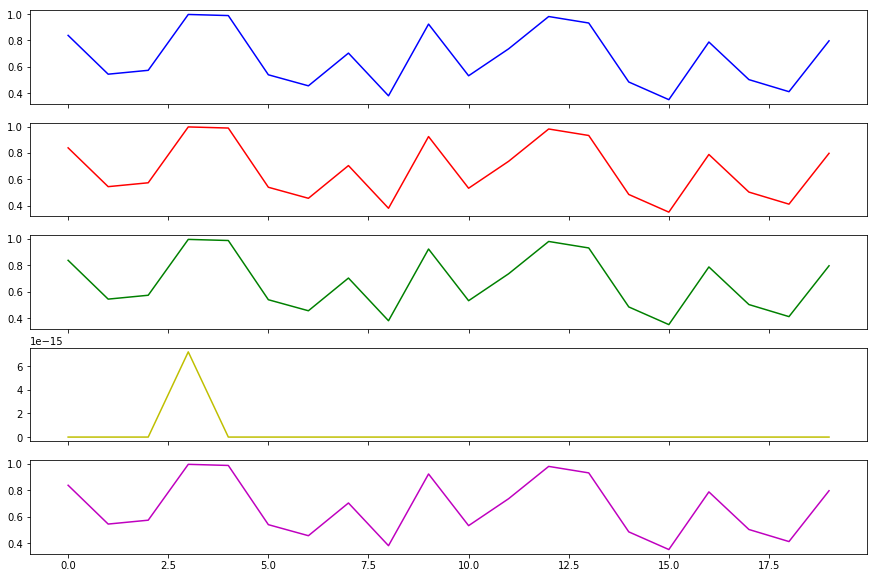

In [105]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,facecolor='white', figsize=(15,10), sharex=True)
ax1.plot(s1[:20], color='b')
ax2.plot(s2[:20], color='r')
ax3.plot(s3[:20], color='g')
ax4.plot(s4[:20], color='y')
ax5.plot(s5[:20], color='m')

In [85]:
my_logits.sum(axis=1)

array([13.54349082,  9.83745455, 12.18899777, ..., 34.25929261,
       58.27931298,  9.98923703])

In [106]:
s1, s2, s3, s4, s5

(array([0.838212  , 0.5442449 , 0.5735516 , ..., 0.55581886, 0.89660704,
        0.7959931 ], dtype=float32),
 array([0.838212  , 0.5442448 , 0.57355165, ..., 0.5558191 , 0.89660716,
        0.79599303], dtype=float32),
 array([0.8382123 , 0.54424405, 0.57355064, ..., 0.5558199 , 0.8966075 ,
        0.79599303], dtype=float32),
 array([7.50301471e-35, 7.32454864e-36, 3.19814375e-35, ...,
        8.77497794e-33, 4.03618977e-31, 5.83820143e-36]),
 array([0.83821197, 0.54424475, 0.57355166, ..., 0.55581903, 0.89660711,
        0.79599305]))

## 결국 알아낸 것: softmax를 제대로 구현하여야한다는 것. 선형대수의 연산 과정에서 매트릭스 연산과 원소차원 연산을 제대로 분리하자!!